<a href="https://colab.research.google.com/github/ekqlsrla/ESAA/blob/main/HW/0523_CH05_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[파이썬 머신러닝 가이드]**
---

# **04 사이킷런 LinearRegression을 이용한 보스턴 주택 가격 예측**

## 1. LinearRegression 클래스 - Ordinary Least Squares

1) `LinearRegression` 클래스 : 예측값과 실제 값의 **RSS**를 최소화해 **OLS(Ordinary Least Squares)** 추정 방식으로 구현한 클래스
* `fit()` 메서드로 배열을 입력 받으면 회귀계수를 `coef_` 속성에 저장

* 입력 피처의 **독립성**에 많은 영향 받음 -> `다중공선성(multi-collinearity)`
```
class sklearn.linear_model.LinearRegression(fit_intercept = True, normalize = False, copy_X = True, n_jobs = 1)
```

(1) 입력 파라미터 
* `fit_intercept` : 불린 값으로 디폴트 = True. intercept 값을 계산할 것인지 말지를 지정
* `normalize` : 불린 값으로 디폴트 = False. True이면 회귀를 수행하기 전에 입력 데이터 세트를 정규화

(2) 속성
* `coef_` : fit()메서드를 수행했을 때 회귀계수가 배열 형태로 저장하는 속성.
* `intercept_` : intercept 값

## 2. 회귀 평가 지표

* `MAE` | Mean Absolute Error : **절댓값**으로 변환해 평균
* `MSE` | Mean Squared Error : **제곱**해 평균
* `RMSE` | MSE에 `Root`를 씌운 것
* `$R^2$ | 분산 기반으로 예측 성능 평가, 실제 값의 분산 대비 예측값의 분산 비율

1) scoring 파라미터의 적용 값

|평가방법|사이킷런 평가 지표 API|Scoring 함수 적용 값|
|---|---|---|
|MAE|metrics.mean_absoulte_error|neg_mean_absolute_error|
|MSE|metrics.mean_squared_error|neg_mean_squared_error|
|$R^2$|metrics.r2_score|r2|

* `neg_` : 값이 커지면 오히려 나쁜 모델이라는 의미이므로 사이킷런의 Scoring암수에 일반적으로 보정

## 3. LinearRegreesion을 이용해 보스턴 주택 가격 회귀 구현

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

#boston 데이터 세트 로드
boston = load_boston()
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

#boston 데이터 세트의 target 배열을 주택 가격이며 이를 Price 칼럼으로 추가
bostonDF["PRICE"] = boston.target
print('Boston 데이터 세트 크기 :',bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기 : (506, 14)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [2]:
bostonDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


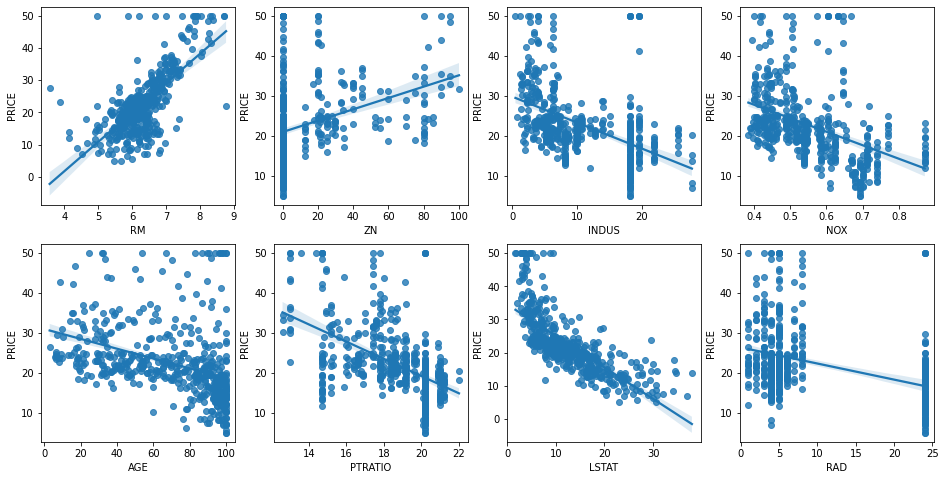

In [13]:
#각 칼럼이 회귀 결과에 미치는 영향 시각화
#2개의 행과 4개의 열을 가진 subplots를 이용. axs는 4x2개의 ax를 가짐

fig,axs = plt.subplots(figsize = (16,8),ncols = 4, nrows = 2)
lm_features = ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD']
for i,feature in enumerate(lm_features) :
  row = int(i/4)
  col = i%4
  #regplot
  sns.regplot(x = feature,y = 'PRICE',data = bostonDF, ax = axs[row][col])

In [15]:
#보스턴 주택 가격의 회귀 모델

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis = 1, inplace = False)

X_train,X_test,y_train,y_test = train_test_split(X_data,y_target, test_size = 0.3, random_state = 156)

#선형 회귀 OLS로 학습/예측/평가 수행
lr = LinearRegression()
lr.fit(X_train,y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test,y_preds)
rmse = np.sqrt(mse)

print("MSE : {0:.3f}, RMSE : {1:.3f}".format(mse,rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test,y_preds)))

MSE : 17.297, RMSE : 4.159
Variance score : 0.757


In [16]:
print('절편 값 : ',lr.intercept_)
print('회귀 계수값 :', np.round(lr.coef_,1))

절편 값 :  40.995595172164755
회귀 계수값 : [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [17]:
#회귀 계수를 큰 값으로 정렬하기 위해 Series로 생성. 인덱스칼럼명에 유의
coeff = pd.Series(data = np.round(lr.coef_,1),index = X_data.columns)
coeff.sort_values(ascending = False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

In [18]:
#교차 검증

from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis = 1,inplace = False)
lr = LinearRegression()

#cross_val_score()로 5 폴드 세트로 MSE를 구한 뒤 이를 기반으로 다시 RMSE 구함
neg_mse_scores = cross_val_score(lr,X_data,y_target,scoring = 'neg_mean_squared_error',cv = 5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

#cross_val_score(scoring = 'neg_mean_squared_error')로 반환된 값은 모두 음수
print('5 folds 의 개별 Negative MSE scores : ', np.round(neg_mse_scores,2))
print('5 folds 의 개별 RMSE scores : ', np.round(rmse_scores,2))
print('5 folds 의 개별 RMSE : {0:.3f}'.format(avg_rmse))

5 folds 의 개별 Negative MSE scores :  [-12.46 -26.05 -33.07 -80.76 -33.31]
5 folds 의 개별 RMSE scores :  [3.53 5.1  5.75 8.99 5.77]
5 folds 의 개별 RMSE : 5.829
